In [22]:

import sklearn
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from bokeh.plotting import figure, show, output_notebook, output_file, save
from sklearn.model_selection import RandomizedSearchCV
# import load_data
# import exponential_modeling
# import fit_and_predict
# import copy

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [23]:
import numpy.random as npr
import numpy.linalg as npl

from scipy.stats import norm as normal
from scipy.stats import laplace as laplace
from scipy.optimize import curve_fit

In [24]:
import matplotlib

cmap = matplotlib.cm.get_cmap('viridis')


In [25]:
df = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv',
                 names = [
        'date', 'state', 'region_code', 'region_name', 'lat',
       'long', 'hospitalized_with_symptoms', 'intensive_care',
       'total_hospitalized', 'home_isolation', 'total_positive',
       'total_positive_change', 'new_positives', 'discharged_healed',
       'total_deaths', 'total_cases', 'swabs', 'note_it', 'note_en'])

pop_df = pd.read_csv('italy_data.txt', delimiter='\t')

In [26]:
df.head() #pop_df.head()

,date,state,region_code,region_name,lat,long,hospitalized_with_symptoms,intensive_care,total_hospitalized,home_isolation,total_positive,total_positive_change,new_positives,discharged_healed,total_deaths,total_cases,swabs,note_it,note_en
0,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en
1,2020-02-24T18:00:00,ITA,13,Abruzzo,42.35122196,13.39843823,0,0,0,0,0,0,0,0,0,0,5,NaN,NaN
2,2020-02-24T18:00:00,ITA,17,Basilicata,40.63947052,15.80514834,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN
3,2020-02-24T18:00:00,ITA,04,P.A. Bolzano,46.49933453,11.35662422,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN
4,2020-02-24T18:00:00,ITA,18,Calabria,38.90597598,16.59440194,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN


In [27]:
df = df.drop([0]) # drop the italian keys row

In [28]:
df = df[df.region_name !='P.A. Bolzano'] 

In [29]:
len(df)

1000

In [30]:
df = pd.merge(df, pop_df, how='outer', on='region_name')
len(df)

1000

In [31]:
df.region_name.unique(), df.region_name.nunique()

(array(['Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Emilia-Romagna',
        'Friuli Venezia Giulia', 'Lazio', 'Liguria', 'Lombardia', 'Marche',
        'Molise', 'Piemonte', 'Puglia', 'Sardegna', 'Sicilia', 'Toscana',
        'P.A. Trento', 'Umbria', "Valle d'Aosta", 'Veneto'], dtype=object), 20)

In [32]:
for key in [
        'region_code',  'lat',
       'long', 'hospitalized_with_symptoms', 'intensive_care',
       'total_hospitalized', 'home_isolation', 'total_positive',
       'total_positive_change', 'new_positives', 'discharged_healed',
       'total_deaths', 'total_cases', 'swabs']:
    df[key] = df[key].astype(float)
df.describe()

,region_code,lat,long,hospitalized_with_symptoms,intensive_care,total_hospitalized,home_isolation,total_positive,total_positive_change,new_positives,discharged_healed,total_deaths,total_cases,swabs,2018_death_rate,2018_deaths,2018_population
count,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03
mean,10.500000,42.873641,12.269422,761.35400,109.138000,870.492000,1262.715000,2133.207000,101.858000,157.359000,474.766000,335.13300,2943.106000,15604.806000,10.900000,31656.650000,3.017977e+06
std,5.769167,2.425620,2.718680,1905.90667,221.130934,2123.117599,2594.394003,4590.063474,208.308133,328.987311,1902.177328,1228.44524,7553.624951,30750.965248,1.265148,24549.888298,2.472177e+06
min,1.000000,38.115697,7.320149,0.00000,0.000000,0.000000,0.000000,0.000000,-386.000000,-17.000000,0.000000,0.00000,0.000000,0.000000,8.800000,1477.000000,1.256660e+05
25%,5.750000,41.054088,10.638510,12.00000,3.000000,15.500000,20.000000,38.000000,2.000000,6.000000,0.000000,0.00000,41.500000,455.750000,9.900000,13376.500000,1.179484e+06
50%,10.500000,43.361759,12.435957,122.00000,26.000000,148.000000,272.000000,495.000000,32.000000,49.000000,14.000000,19.00000,530.500000,3576.000000,11.150000,20997.000000,1.793361e+06
75%,15.250000,45.163682,13.888815,600.25000,113.250000,701.250000,1167.750000,1875.750000,106.000000,141.500000,164.750000,159.00000,2254.000000,15558.250000,11.650000,50354.000000,4.571071e+06
max,20.000000,46.068935,16.867367,12028.00000,1381.000000,13328.000000,18764.000000,31935.000000,1950.000000,3251.000000,17478.000000,10901.00000,60314.000000,211092.000000,14.300000,99542.000000,1.006057e+07


In [33]:
def log_model_gauss(t, p, a, b):
    return(np.log(model_gauss(t, p, a, b)))

In [34]:
def model_laplace(t, p, a, b):
    return(p*laplace.cdf(a*(t-b)))
def model_gauss(t, p, a, b):
    return(p*normal.cdf(a*(t-b)))

In [35]:
## Death peak vs cases peak

## FIrst comparison between Lplace and Gauss

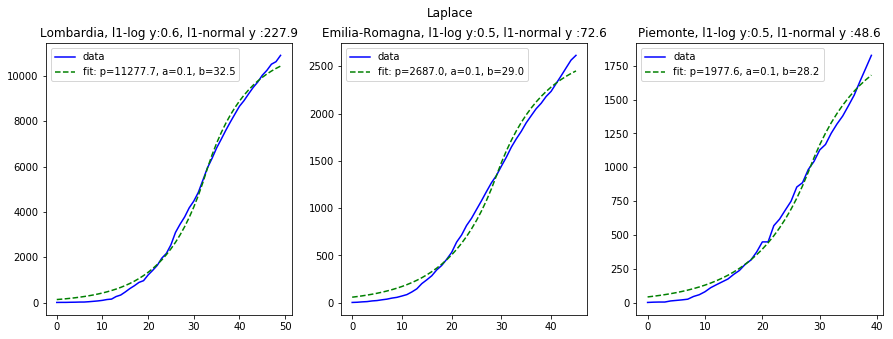

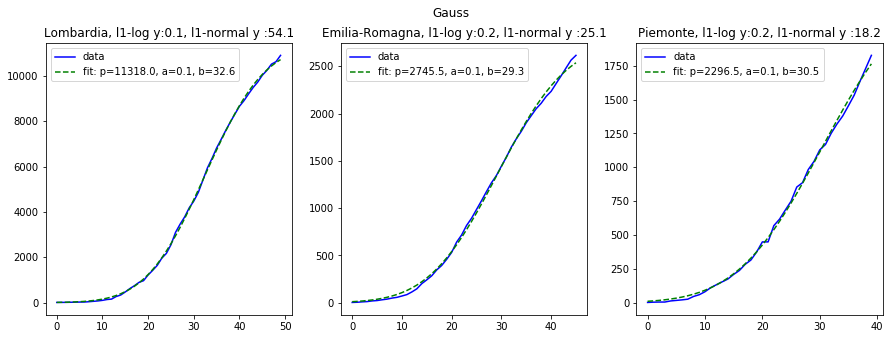

In [36]:
dfg = df.groupby('region_name')

for model, label in  zip([model_laplace, model_gauss], ['Laplace', 'Gauss']):
    plt.figure(figsize=[15, 5])
    for j, grp in enumerate(['Lombardia', 'Emilia-Romagna', 'Piemonte']):
        group = dfg.get_group(grp).reset_index()
        group["death_rate"] = group["total_deaths"] / group['2018_population']
        y = group[group["death_rate"]>np.exp(-15)]["total_deaths"].values
        x = np.arange(len(y))
        popt, pcov = curve_fit(model, x, y, bounds=(0., [12000, 1., 100.]), p0=[10000, 0.5, 5.])
        y_fit =  model(x, *popt)
        plt.subplot(1, 3, j+1)
        plt.plot(x, y, 'b-', label='data')
        plt.plot(x, y_fit, 'g--',label='fit: p=%.1f, a=%.1f, b=%.1f' % tuple(popt))
        l1_error_log_y = np.mean(np.abs(np.log(1+y)-np.log(1+y_fit)))
        l1_error = np.mean(np.abs(y-y_fit))
        plt.legend()
        plt.title('%s, l1-log y:%.1f, l1-normal y :%.1f'%(grp, l1_error_log_y, l1_error))
    plt.suptitle(label)
    plt.show()

## Comparing Perturbation effects on the fit (on a subset of data)

### Odd/Even data : its okay as long as long as there are enough data points

In [37]:
# grp_names = ['Abruzzo', 'Basilicata', 'Emilia-Romagna', 'Toscana', 'Veneto']
# errors = np.zeros((2, len(grp_names)))
# log_errors =  np.zeros((2, len(grp_names)))
# lap_params =  np.zeros((len(grp_names), 3))
# gauss_params =  np.zeros((len(grp_names), 3))

# test_offset = -4
# i = 0

# for model, label, color, params in  zip([model_laplace, model_gauss], ['Lap', 'Gauss'], ['green', 'orange'],[lap_params, gauss_params]):
#     plt.figure(figsize=[25, 5])
#     for j, grp in enumerate(grp_names):
#         for start, lss in zip([0, 1], ['--', '-.']):
#             group = dfg.get_group(grp).reset_index()
#             group["death_rate"] = group["total_deaths"] / group['2018_population']
#             yvec = group[group["death_rate"]>np.exp(-15)]["total_deaths"].values
#             x = np.arange(start, len(yvec)+test_offset, 2)
#             y = yvec[x]

#             y_test = yvec[max(x):]
#             x_test = np.arange(max(x), len(yvec))

#             plt.subplot(1, 5, j+1)
#             plt.plot(x, y, 'b*', label='train data')
#             plt.plot(x_test, y_test, 'r*', label='test-data')
#             if len(y) > 4:
#                 popt, pcov = curve_fit(model, x, y, bounds=(0., [12000, 1., 100.]), p0=[10000, 0.5, 5.])
#                 y_fit =  model(x, *popt)
#                 log_errors[i, j] = np.mean(np.abs(np.log(1+y)-np.log(1+y_fit)))
#                 errors[i, j] = np.mean(np.abs(y-y_fit))
#                 params[j, :] = np.asarray(popt)
#                 plt.plot(x, y_fit, color=color, linestyle='--', label='%s, logE=%.1f, linE=%.1f' %(label, log_errors[i, j], errors[i, j]))
#                 plt.plot(np.arange(0, 50), model(np.arange(0, 50), *popt), color=color, linestyle=lss, linewidth=3.)
#                 print(grp, label, *popt)
#             plt.legend()
#             plt.title(grp)
#         # plt.suptitle(label)
#     plt.show()
#     i += 1

### Stability to number of data points: If early in the stage, too unstable

In [38]:
# grp_names = ['Abruzzo', 'Basilicata', 'Emilia-Romagna', 'Toscana', 'Veneto']
# errors = np.zeros((2, len(grp_names)))
# log_errors =  np.zeros((2, len(grp_names)))
# lap_params =  np.zeros((len(grp_names), 3))
# gauss_params =  np.zeros((len(grp_names), 3))

# test_offset = -1
# i = 0

# for model, label, color, params in  zip([model_laplace, model_gauss], ['Lap', 'Gauss'], ['green', 'orange'],[lap_params, gauss_params]):
#     plt.figure(figsize=[25, 5])
#     for j, grp in enumerate(grp_names):
#         for test_offset, lss in zip([-1, -4, -6], ['--', '-.', ':']):
#             group = dfg.get_group(grp).reset_index()
#             group["death_rate"] = group["total_deaths"] / group['2018_population']
#             yvec = group[group["death_rate"]>np.exp(-15)]["total_deaths"].values
#             x = np.arange(start, len(yvec)+test_offset)
#             y = yvec[x]

#             y_test = yvec[max(x):]
#             x_test = np.arange(max(x), len(yvec))

#             plt.subplot(1, 5, j+1)
#             if test_offset==-1:
#                 plt.plot(x, y, 'b*', label='train data')
#                 plt.plot(x_test, y_test, 'r*', label='test-data')
#             if len(y) > 4:
#                 popt, pcov = curve_fit(model, x, y, bounds=(0., [12000, 1., 100.]), p0=[10000, 0.5, 5.])
#                 y_fit =  model(x, *popt)
#                 log_errors[i, j] = np.mean(np.abs(np.log(1+y)-np.log(1+y_fit)))
#                 errors[i, j] = np.mean(np.abs(y-y_fit))
#                 params[j, :] = np.asarray(popt)
#                 plt.plot(x, y_fit, color=color, linestyle='--', label='%s, logE=%.1f, linE=%.1f' %(label, log_errors[i, j], errors[i, j]))
#                 plt.plot(np.arange(0, 50), model(np.arange(0, 50), *popt), color=color, linestyle=lss, linewidth=3.)
#                 print(grp, label, *popt)
#             plt.legend()
#             plt.title(grp)
#         # plt.suptitle(label)
#     plt.show()
#     i += 1

### Stability to Initialization: Gaussian very stable

In [39]:
# grp_names = ['Abruzzo', 'Basilicata', 'Emilia-Romagna', 'Toscana', 'Veneto']
# errors = np.zeros((2, len(grp_names)))
# log_errors =  np.zeros((2, len(grp_names)))
# lap_params =  np.zeros((len(grp_names), 3))
# gauss_params =  np.zeros((len(grp_names), 3))

# test_offset = -5
# i = 0

# for model, label, color, params in  zip([model_laplace, model_gauss], ['Lap', 'Gauss'], ['green', 'orange'],[lap_params, gauss_params]):
#     plt.figure(figsize=[25, 5])
#     for j, grp in enumerate(grp_names):
#         for lss in ['--', '-.', ':']:
#             group = dfg.get_group(grp).reset_index()
#             group["death_rate"] = group["total_deaths"] / group['2018_population']
#             yvec = group[group["death_rate"]>np.exp(-18)]["total_deaths"].values
#             x = np.arange(start, len(yvec)+test_offset)
#             y = yvec[x]

#             y_test = yvec[max(x):]
#             x_test = np.arange(max(x), len(yvec))

#             plt.subplot(1, 5, j+1)
#             if lss=='--':
#                 plt.plot(x, y, 'b*', label='train data')
#                 plt.plot(x_test, y_test, 'r*', label='test-data')
#             if len(y) > 4:
#                 p0 = [500*npr.rand(), npr.rand(), 5*npr.rand()]
#                 popt, pcov = curve_fit(model, x, y, bounds=(0., [12000, 1., 100.]), p0=p0, loss='linear')
#                 y_fit =  model(x, *popt)
#                 log_errors[i, j] = np.mean(np.abs(np.log(1+y)-np.log(1+y_fit)))
#                 errors[i, j] = np.mean(np.abs(y-y_fit))
#                 params[j, :] = np.asarray(popt)
#                 plt.plot(x, y_fit, color=color, linestyle='--', label='%s, logE=%.1f, linE=%.1f' %(label, log_errors[i, j], errors[i, j]))
#                 plt.plot(np.arange(0, 50), model(np.arange(0, 50), *popt), color=color, linestyle=lss, linewidth=3.)
#                 print(grp, label, p0, *popt)
#             plt.legend()
#             plt.title(grp)
#         # plt.suptitle(label)
#     plt.show()
#     i += 1

### Stability to loss function: least squares looks most sensible, soft_l1 can be weird, cauchy/arctan are pretty weird.

In [40]:
# grp_names = ['Abruzzo', 'Basilicata', 'Emilia-Romagna', 'Toscana', 'Veneto']
# errors = np.zeros((2, len(grp_names)))
# log_errors =  np.zeros((2, len(grp_names)))
# lap_params =  np.zeros((len(grp_names), 3))
# gauss_params =  np.zeros((len(grp_names), 3))

# test_offset = -5
# i = 0

# for model, label, color, params in  zip([model_laplace, model_gauss], ['Lap', 'Gauss'], ['green', 'orange'],[lap_params, gauss_params]):
#     plt.figure(figsize=[25, 5])
#     for j, grp in enumerate(grp_names):
#         for loss, lss in zip(['linear', 'soft_l1', 'arctan'], ['--', '-.', ':']):
#             group = dfg.get_group(grp).reset_index()
#             group["death_rate"] = group["total_deaths"] / group['2018_population']
#             yvec = group[group["death_rate"]>np.exp(-18)]["total_deaths"].values
#             x = np.arange(start, len(yvec)+test_offset)
#             y = yvec[x]

#             y_test = yvec[max(x):]
#             x_test = np.arange(max(x), len(yvec))

#             plt.subplot(1, 5, j+1)
#             if lss=='--':
#                 plt.plot(x, y, 'b*', label='train data')
#                 plt.plot(x_test, y_test, 'r*', label='test-data')
#             if len(y) > 4:
#                 p0 = [500, 0.5, 2.]
#                 popt, pcov = curve_fit(model, x, y, bounds=(0., [12000, 1., 100.]), p0=p0, loss=loss)
#                 y_fit =  model(x, *popt)
#                 log_errors[i, j] = np.mean(np.abs(np.log(1+y)-np.log(1+y_fit)))
#                 errors[i, j] = np.mean(np.abs(y-y_fit))
#                 params[j, :] = np.asarray(popt)
# #                 plt.plot(x, y_fit, color=color, linestyle='--')
#                 plt.plot(np.arange(0, 50), model(np.arange(0, 50), *popt), color=color, linestyle=lss, linewidth=3., label='%s, logE=%.1f, linE=%.1f' %(loss, log_errors[i, j], errors[i, j]))
#                 print(grp, label, p0, *popt)
#             plt.legend()
#             plt.title(grp)
#         # plt.suptitle(label)
#     plt.show()
#     i += 1

### Exahusitive Comparison: Laplace vs Gaussian: Gaussian has smaller error on linear scale for all states, on log scale worse for a couple of small states Basilicata/Sicilia 

In [41]:
# grp_names = dfg.groups.keys()
# errors = np.zeros((2, len(grp_names)))
# log_errors =  np.zeros((2, len(grp_names)))
# lap_params =  np.zeros((len(grp_names), 3))
# gauss_params =  np.zeros((len(grp_names), 3))

# test_offset = -5
# plt.figure(figsize=[30, 15])
# for j, grp in enumerate(grp_names):
#     group = dfg.get_group(grp).reset_index()
#     group["death_rate"] = group["total_deaths"] / group['2018_population']
#     y = group[group["death_rate"]>np.exp(-15)]["total_deaths"].values[:test_offset]
#     x = np.arange(len(y))
    
#     y_test = group[group["death_rate"]>np.exp(-15)]["total_deaths"].values[test_offset:]
#     x_test = np.arange(len(x), len(x)+len(y_test))
    
#     plt.subplot(3, 7, j+1)
#     plt.plot(x, y, 'b-', label='data')
#     plt.plot(x_test, y_test, 'm*', label='test-data')
#     if len(y) > 5:
#         i = 0
#         for model, label, color, params in  zip([model_laplace, model_gauss], ['Lap', 'Gauss'], ['green', 'red'],[lap_params, gauss_params]):
#             popt, pcov = curve_fit(model, x, y, bounds=(0., [12000, 1., 100.]), p0=[10000, 0.5, 5.])
#             y_fit =  model(x, *popt)
#             log_errors[i, j] = np.mean(np.abs(np.log(1+y)-np.log(1+y_fit)))
#             errors[i, j] = np.mean(np.abs(y-y_fit))
#             params[j, :] = np.asarray(popt)
#             plt.plot(x, y_fit, color=color, linestyle='--', label='%s, logE=%.1f, linE=%.1f' %(label, log_errors[i, j], errors[i, j]))
#             plt.plot(x_test, model(x_test, *popt), color=color, linestyle=':', linewidth=3.)
#             i += 1
#     plt.legend()
#     plt.title(grp)
# # plt.suptitle(label)
# plt.show()

NameError: name 'errors' is not defined

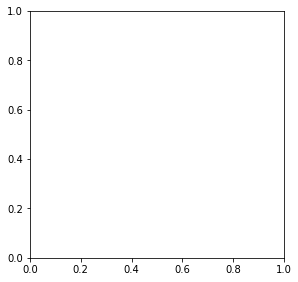

In [42]:
plt.figure(figsize=[10, 10])
plt.subplot(221)
plt.hist(errors[0, :], label='Lap')
plt.hist(errors[1, :], label='Gauss')
plt.legend()
plt.title('Linear Scale L-1 Error')
plt.subplot(222)
plt.hist(log_errors[0, :], label='Lap')
plt.hist(log_errors[1, :], label='Gauss')
plt.legend()
plt.title('Log Scale L-1 Error')
plt.subplot(223)
plt.scatter(errors[0, :], errors[1, :])
plt.plot([0, 100], [0, 100], 'k--', alpha=0.5)
plt.xlabel('Laplace')
plt.ylabel('Gauss')
plt.title('Linear Scale L-1 Error')
plt.subplot(224)
plt.scatter(log_errors[0, :], log_errors[1, :])
plt.plot([0, 0.6], [0, 0.6], 'k--', alpha=0.5)
plt.xlabel('Laplace')
plt.ylabel('Gauss')
plt.title('Log Scale L-1 Error')
plt.show()

### Patterns in the parameters

In [43]:
# for field in ['2018_population', '2018_death_rate']:
#     feat = np.zeros(lap_params.shape[0])
#     for i, grp in enumerate(grp_names):
#         group = dfg.get_group(grp).reset_index()
#         feat[i] = group[field][0]

#     for params in [lap_params, gauss_params]:
#         plt.figure(figsize=[12, 5])
#         for j in [0, 1, 2]:
            
#             plt.subplot(1, 3, j+1)
#             X = params[:,j].reshape(-1, 1)
#             y = feat
#             lm = LinearRegression()
#             lm.fit(X, y)
#             print(lm.coef_, lm.score(X, y))
            
#             plt.scatter(X.flatten(), y)
#             plt.plot(X.flatten(), lm.predict(X), 'k--', alpha=0.5)


Emilia-Romagna 46 11.2 0.0004888465620520074
Lombardia 50 9.9 0.0009426897511016766
Piemonte 40 12.4 0.00030277251477479374


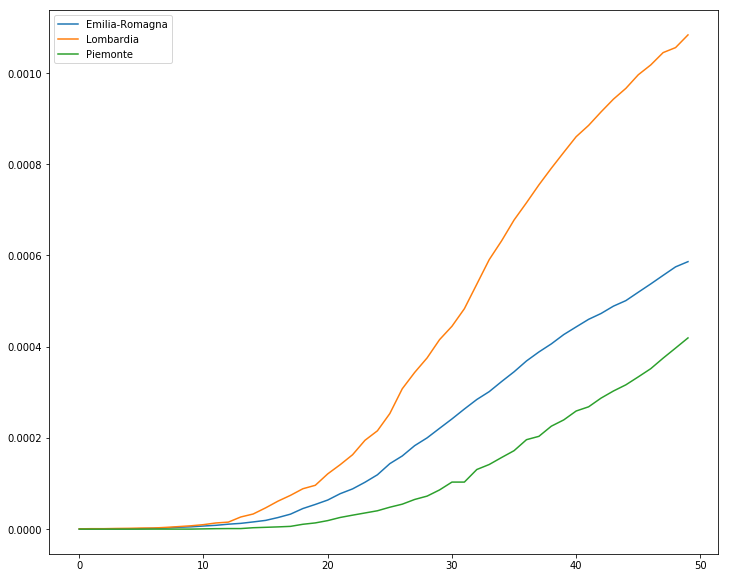

In [44]:
dfg = df.groupby('region_name')
plt.figure(figsize=[12, 10])
for name, group in dfg:
    group = group.reset_index()
    group["death_rate"] = group["total_deaths"] / group['2018_population']
#     print(name, np.asarray(group["hospitalized_with_symptoms"])[-1])
    if name  in ['Lombardia', 'Emilia-Romagna', 'Piemonte']:
        plt.plot(group["death_rate"], label=name)
        print(name, np.sum(group["death_rate"]> np.exp(-15.)), group["2018_death_rate"][0], 
              group["death_rate"][43])
plt.legend()
plt.show()

### Lag between peaks in new deaths and new positives: Peaks are not well-defined both for new deaths ad new positives

- smoothening helps little bit and suggests that the lag can lie b/w 0 to 10 (mean 5, std 5)

## Whole Country

In [83]:
np.max(y)/3

319.0

In [148]:
y = dd["total_cases"].sum()-dd["total_cases"].sum().shift(1)
smooth_y =  y.rolling(window=w)
smooth_y = smooth_y.mean()
print(smooth_y[-1])
np.where(np.abs(smooth_y-smooth_y[-1])<500)

3915.0


(array([23, 24, 36, 37, 42, 43, 44, 45, 46, 47, 48, 49]),)

In [144]:
np.where(np.abs(smooth_y-smooth_y[-1])<100)

(array([46, 49]),)

In [177]:
y = dd["total_deaths"].sum()-dd["total_deaths"].sum().shift(1)


In [178]:
y[-1]

559.0

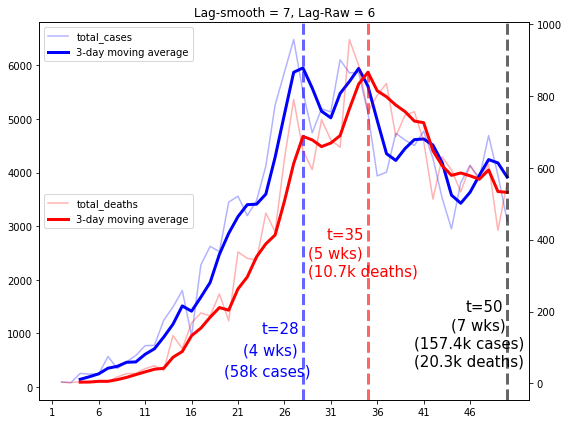

In [190]:
w = 3
plt.figure(figsize=[8, 6])
y = dd["total_cases"].sum()-dd["total_cases"].sum().shift(1)
t = np.arange(1, len(y)+1)
# y = y.reset_index()
# y = pd.Series(y.values)
plt.plot(t, y, color='b', alpha=0.3)

smooth_y =  y.rolling(window=w)
smooth_y = smooth_y.mean()
plt.plot(t, smooth_y, color='b', linewidth=3., label='%d-day moving average'%w)
x1, x2 = np.argmax(y), np.argmax(smooth_y)
plt.axvline(x= x2+1, color='b', alpha=0.6, linestyle='--', linewidth=3.)
plt.text(x=x2-3.5, y=1000., s='t=%d'%(x2+1), color='b', fontsize=15)
plt.text(x=x2-5.5, y=600., s='(4 wks)', color='b', fontsize=15)
temp = dd["total_cases"].sum()[x2]/1000
plt.text(x=x2-7.5, y=200., s='(%dk cases)'%temp, color='b', fontsize=15)

plt.legend(loc='upper left')

ax = plt.gca().twinx()

y = dd["total_deaths"].sum()-dd["total_deaths"].sum().shift(1)
ax.plot(t, y, color='r', alpha=0.3)
smooth_y =  y.rolling(window=w)
smooth_y = smooth_y.mean()
ax.plot(t, smooth_y, color='r', linewidth=3., label='%d-day moving average'%w)
x3, x4 = np.argmax(y), np.argmax(smooth_y)
ax.axvline(x= x4+1, color='r', alpha=0.6, linestyle='--', linewidth=3.)
ax.text(x=x4-3.5, y=400, s='t=%d'%(x4+1), color='r', fontsize=15)
ax.text(x=x4-5.5, y=350, s='(5 wks)', color='r', fontsize=15)
temp = dd["total_deaths"].sum()[x4]
plt.text(x=x4-5.5, y=300., s='(%.1fk deaths)'%(temp/1000), color='r', fontsize=15)


ax.axvline(x= len(y), color='k', alpha=0.6, linestyle='--', linewidth=3.)
ax.text(x=len(y)-4.5, y=200, s='t=%d'%len(y), color='k', fontsize=15)
ax.text(x=len(y)-6, y=150., s='(7 wks)', color='k', fontsize=15)
temp = dd["total_cases"].sum()[-1]
plt.text(x=len(y)-10, y=100., s='(%.1fk cases)'%(temp/1000), color='k', fontsize=15)
temp = dd["total_deaths"].sum()[-1]
plt.text(x=len(y)-10, y=50., s='(%.1fk deaths)'%(temp/1000), color='k', fontsize=15)

plt.legend(loc='center left')
plt.title('Lag-smooth = %d, Lag-Raw = %d'%(x4-x2, x3-x1))
plt.xticks(np.arange(1, len(y)+1, 5), np.arange(1, len(y)+1, 5))
plt.tight_layout()
# plt.suptitle('%s (blue) vs %s (red)'%(f1, f2), y=1.02)
plt.show()

In [ ]:
w = 3
plt.figure(figsize=[8, 6])
y = dd["total_cases"].sum()-dd["total_cases"].sum().shift(1)
t = np.arange(1, len(y)+1)
# y = y.reset_index()
# y = pd.Series(y.values)
# plt.plot(t, y, color='b', alpha=0.3)

smooth_y =  y.rolling(window=w)
smooth_y = smooth_y.mean()
plt.plot(t, smooth_y, color='b', linewidth=3., label='%d-MA'%w)
x1, x2 = np.argmax(y), np.argmax(smooth_y)
plt.axvline(x= x2+1, color='b', alpha=0.6, linestyle='--', linewidth=3.)
plt.text(x=x2-3.5, y=np.max(y)/9., s='t=%d'%(x2+1), color='b', fontsize=15)
plt.text(x=x2-5.5, y=300., s='(4 wks)', color='b', fontsize=15)

plt.legend(loc='upper left')

ax = plt.gca().twinx()

y = dd["total_deaths"].sum()-dd["total_deaths"].sum().shift(1)
ax.plot(t, y, color='r', alpha=0.3)
smooth_y =  y.rolling(window=w)
smooth_y = smooth_y.mean()
ax.plot(t, smooth_y, color='r', linewidth=3., label='%d-MA'%w)
x3, x4 = np.argmax(y), np.argmax(smooth_y)
ax.axvline(x= x4+1, color='r', alpha=0.6, linestyle='--', linewidth=3.)
ax.text(x=x4-3.5, y=np.max(y)/10, s='t=%d'%(x4+1), color='r', fontsize=15)
ax.text(x=x4-5.5, y=40, s='(5 wks)', color='r', fontsize=15)


ax.axvline(x= len(y), color='k', alpha=0.6, linestyle='--', linewidth=3.)
ax.text(x=len(y)-4.5, y=np.max(y)/10, s='t=%d'%len(y), color='k', fontsize=15)
ax.text(x=len(y)-6, y=40., s='(7 wks)', color='k', fontsize=15)
plt.legend(loc='center left')
plt.title('Lag-smooth = %d, Lag-Raw = %d'%(x4-x2, x3-x1))
plt.tight_layout()
# plt.suptitle('%s (blue) vs %s (red)'%(f1, f2), y=1.02)
plt.show()

## State wise

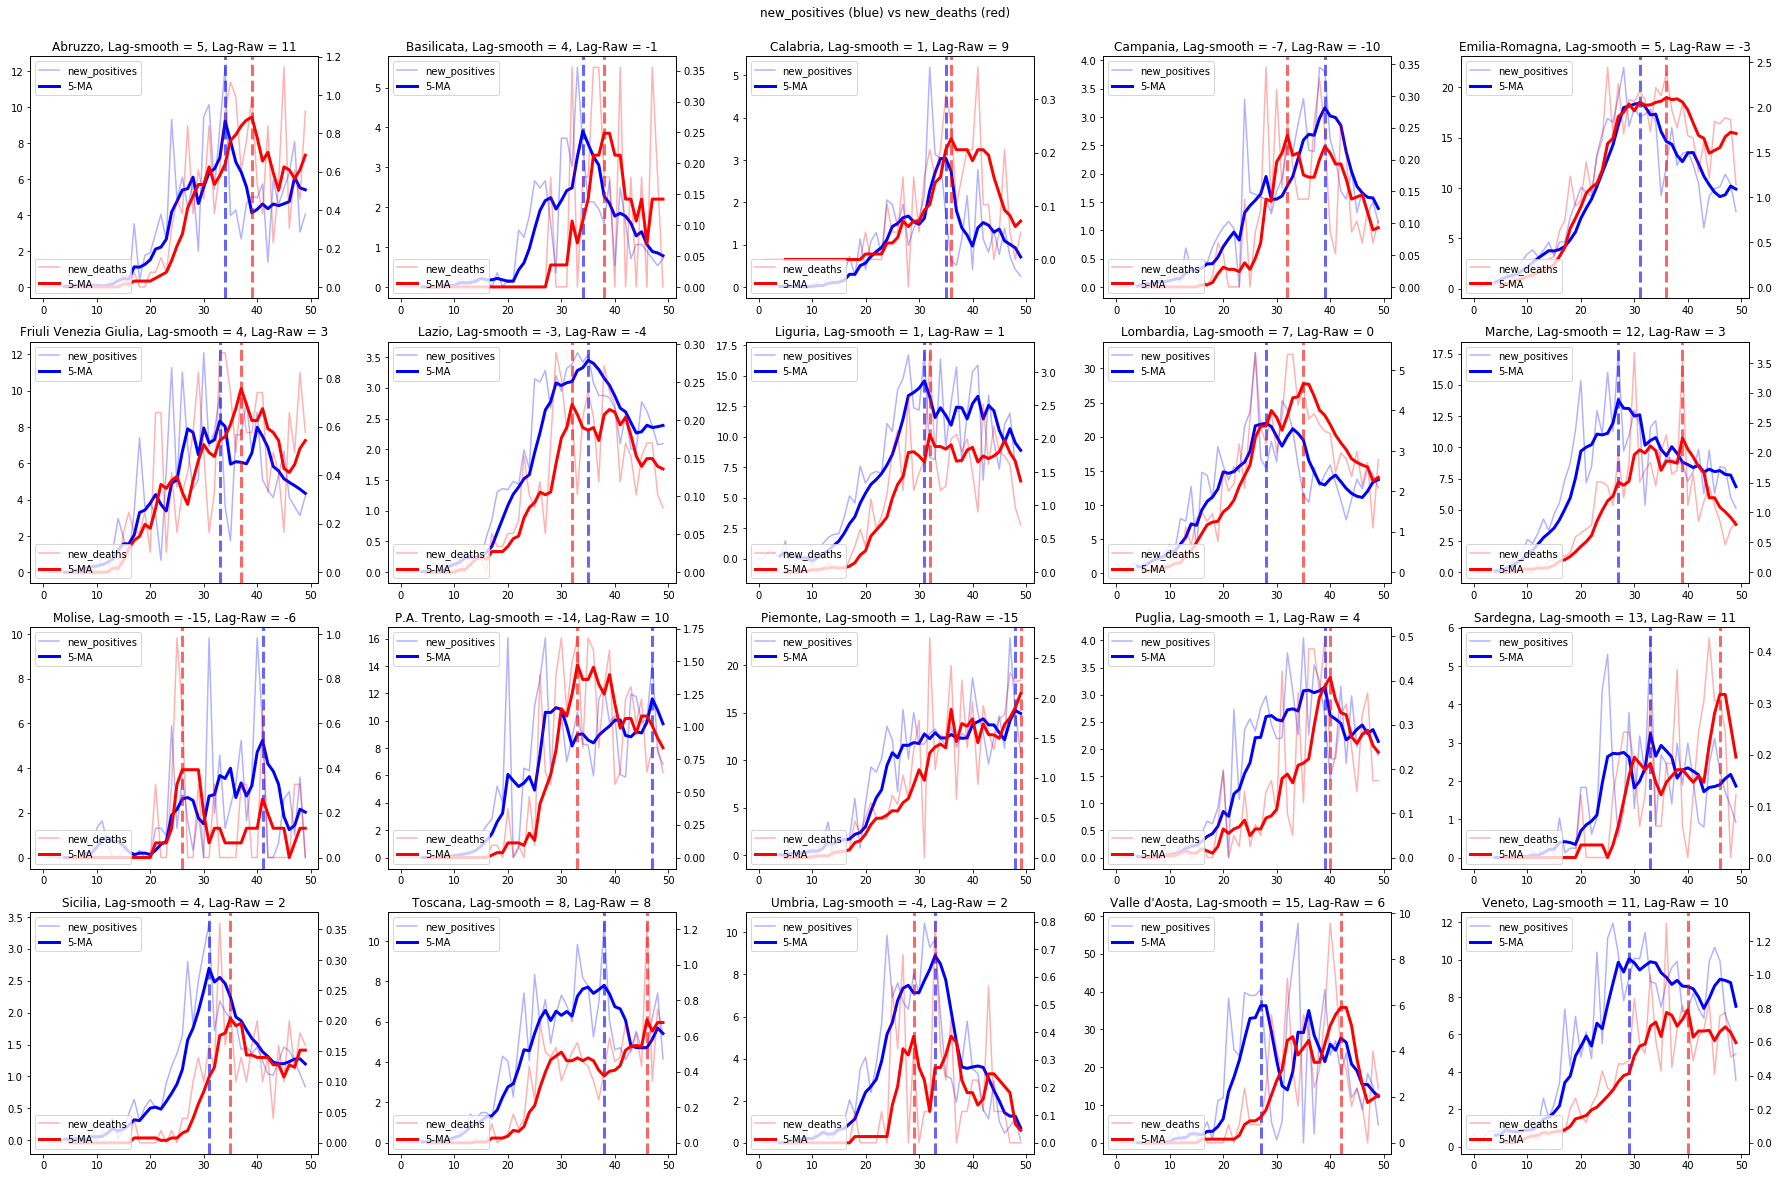

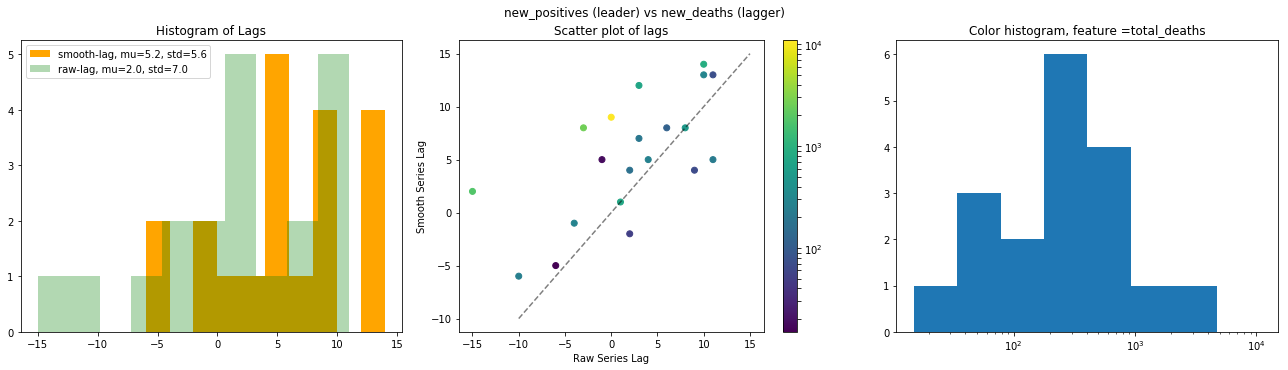

In [48]:
# grp_names = ['Abruzzo', 'Basilicata', 'Emilia-Romagna', 'Toscana', 'Veneto']
w = 5

f1, f2 = "new_positives", "new_deaths" 
f3 = 'total_deaths'
# f1, f2 = "new_intensive_care", "new_deaths"
deltas = np.zeros(len(dfg.groups.keys()))
deltas_smooth = np.zeros(len(dfg.groups.keys()))
plt.figure(figsize=[25, 16])
for j, grp in enumerate(dfg.groups.keys()):
    group = dfg.get_group(grp).reset_index()
    plt.subplot(4, 5, j+1)
    group['new_deaths'] = group['total_deaths'] - group['total_deaths'].shift(1)
    group['new_hospitalized'] = group['total_hospitalized'] - group['total_hospitalized'].shift(1)
    group['new_intensive_care'] = group['intensive_care'] - group['intensive_care'].shift(1)
    group['new_home_isolation'] = group['home_isolation'] - group['home_isolation'].shift(1)
    
    y = group[f1] /  group["2018_population"][0] * 1e5
    plt.plot(y, color='b', alpha=0.3)
    smooth_y =  y.rolling(window=w)
    smooth_y = smooth_y.mean()
    plt.plot(smooth_y, color='b', linewidth=3., label='%d-MA'%w)
    x1, x2 = np.argmax(y), np.argmax(smooth_y)
    plt.axvline(x= x2, color='b', alpha=0.6, linestyle='--', linewidth=3.)
    plt.legend(loc='upper left')

    ax = plt.gca().twinx()
    
    y = group[f2] /  group["2018_population"][0]* 1e5
    ax.plot(y, color='r', alpha=0.3)
    smooth_y =  y.rolling(window=w)
    smooth_y = smooth_y.mean()
    ax.plot(smooth_y, color='r', linewidth=3., label='%d-MA'%w)
    x3, x4 = np.argmax(y), np.argmax(smooth_y)
    ax.axvline(x= x4, color='r', alpha=0.6, linestyle='--', linewidth=3.)
    plt.legend(loc='lower left')

    deltas_smooth[j] = x4-x1
    deltas[j] = x3-x1
    plt.title('%s, Lag-smooth = %d, Lag-Raw = %d'%(grp, x4-x2, x3-x1))
plt.tight_layout()
plt.suptitle('%s (blue) vs %s (red)'%(f1, f2), y=1.02)
plt.show()

plt.figure(figsize=[18, 5])
plt.subplot(131)
plt.hist(deltas_smooth, bins=10, color='orange', label='smooth-lag, mu=%.1f, std=%.1f'%(np.mean(deltas_smooth), np.std(deltas_smooth)))
plt.hist(deltas, bins=10, alpha=0.3,  color='g', label='raw-lag, mu=%.1f, std=%.1f'%(np.mean(deltas), np.std(deltas)))
plt.legend()
plt.title('Histogram of Lags')

feat = np.zeros(len(dfg.groups.keys()))
for j, grp in enumerate(dfg.groups.keys()):
    group = dfg.get_group(grp).reset_index()
    feat[j] = group[f3].tail(1).values[0]
# feat = np.log(1+feat)
# feat /= max(feat)
plt.subplot(132)
plt.scatter(deltas, deltas_smooth,  c=feat, df.='viridis', norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.plot([-10, 15], [-10, 15], 'k--', alpha=0.5)
plt.title('Lag for %s from %s (Color by %s)'%(f1, f2, f3))
plt.xlabel('Raw Series Lag')
plt.ylabel('Smooth Series Lag')
plt.title('Scatter plot of lags')

plt.subplot(133)
hist, bins = np.histogram(feat, bins=8)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.hist(feat, bins=logbins)
plt.xscale('log')
plt.title('Color histogram, feature =%s'%f3)
plt.suptitle('%s (leader) vs %s (lagger)'%(f1, f2), y=1.02)
plt.tight_layout()

plt.show()

## Lag between cumulative (Total) deaths and

- total positive cases so far     : 1-5 days, 
- total "currently" positive cases: 3-7 days, 
- total "currently" hospitalized  : 5-11 days, 
- total "currently" in ICU        : 7-13 days

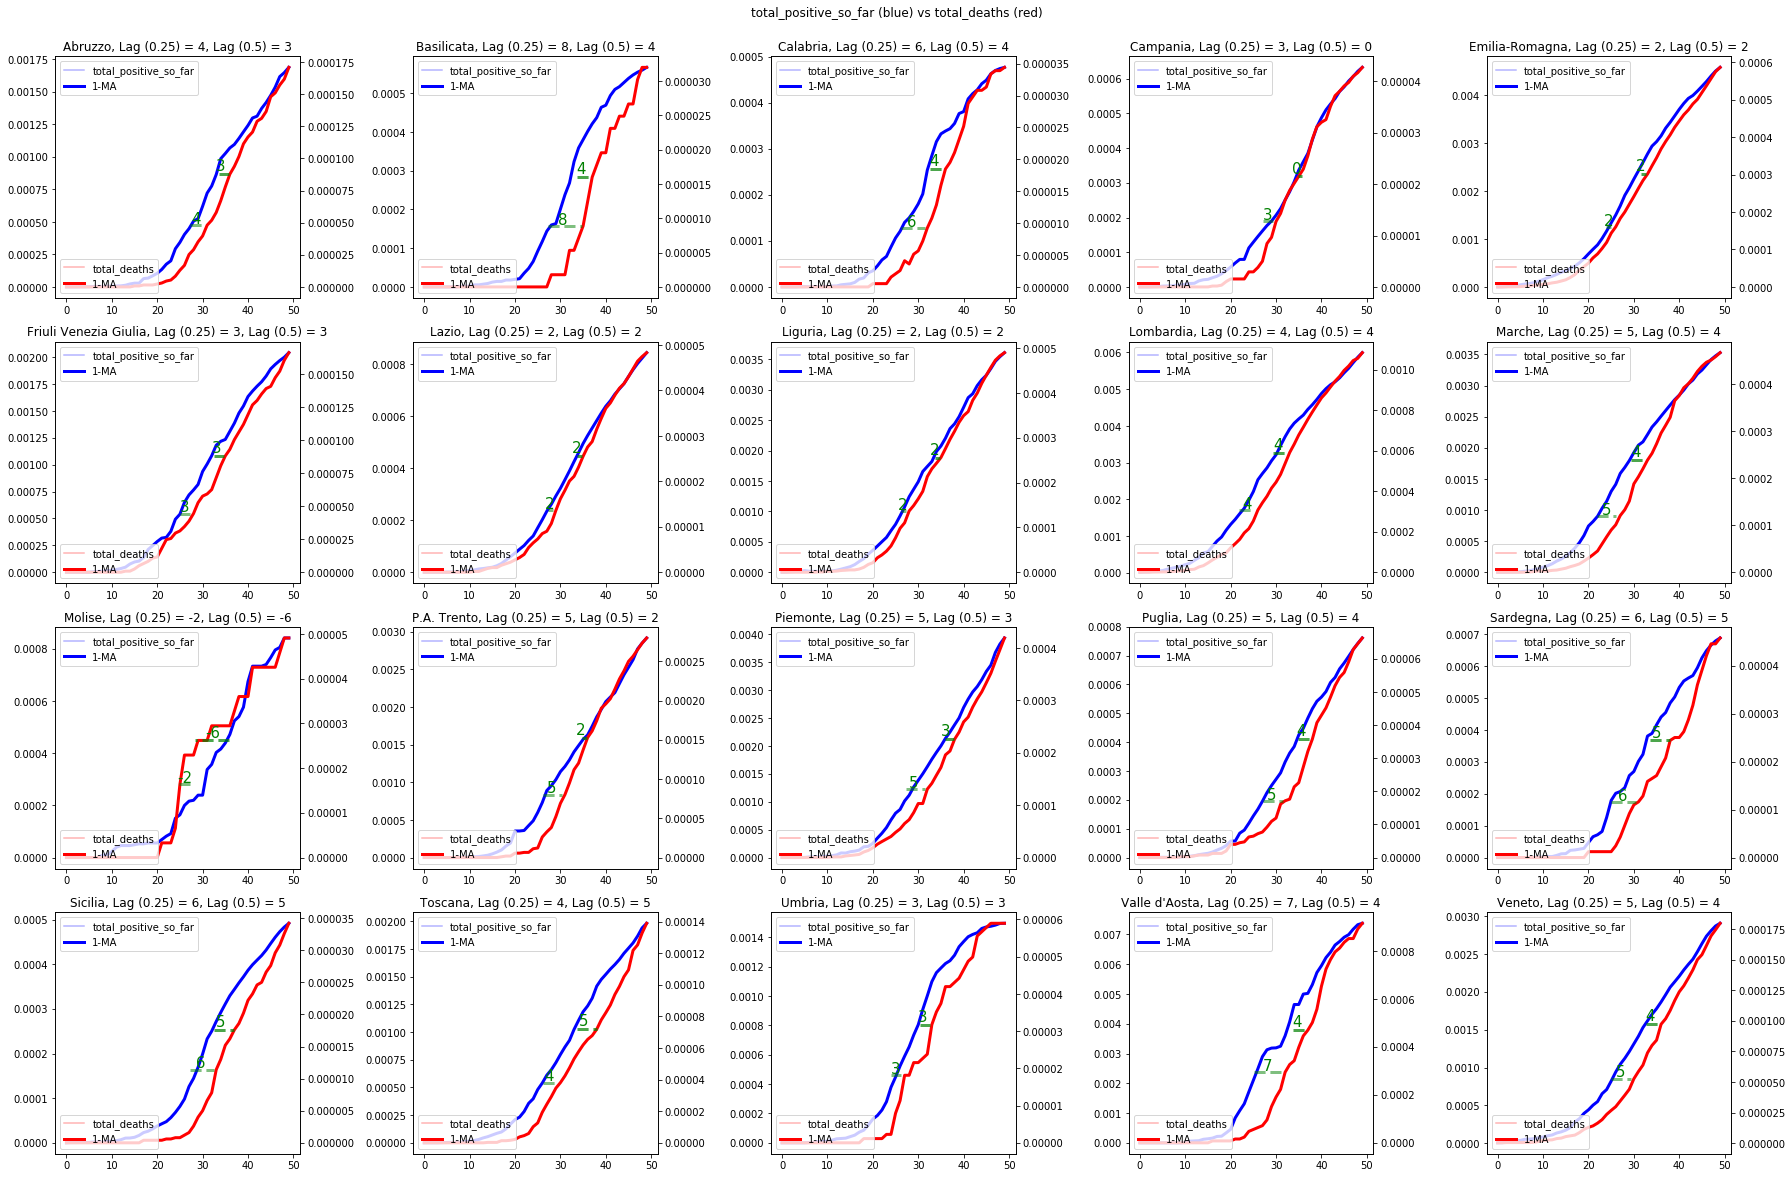

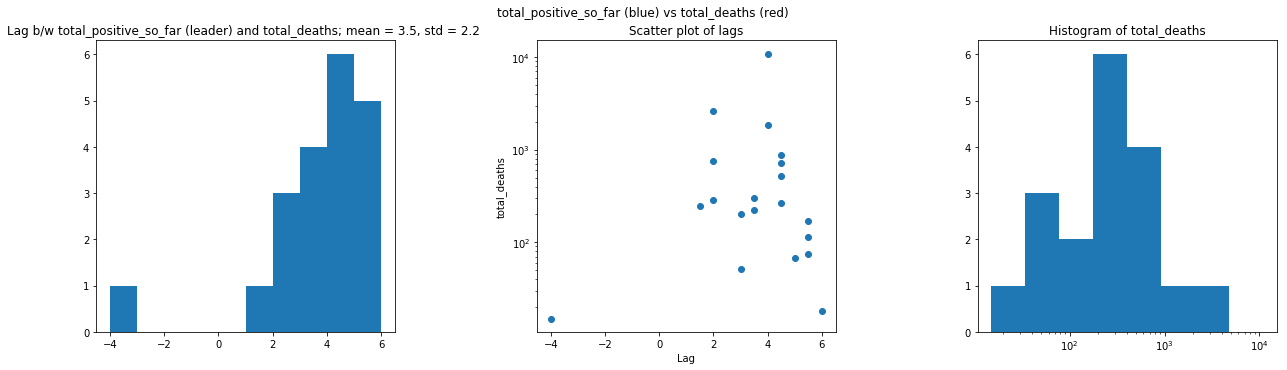

In [46]:
# grp_names = ['Abruzzo', 'Basilicata', 'Emilia-Romagna', 'Toscana', 'Veneto']
w = 1

f1, f2 = "total_positive_so_far", "total_deaths" 
deltas = np.zeros((len(dfg.groups.keys()), 2))

plt.figure(figsize=[25, 16])
for j, grp in enumerate(dfg.groups.keys()):
    group = dfg.get_group(grp).reset_index()
    plt.subplot(4, 5, j+1)
    group['new_deaths'] = group['total_deaths'] - group['total_deaths'].shift(1)
    group['new_hospitalized'] = group['total_hospitalized'] - group['total_hospitalized'].shift(1)
    group['new_intensive_care'] = group['intensive_care'] - group['intensive_care'].shift(1)
    group['new_home_isolation'] = group['home_isolation'] - group['home_isolation'].shift(1)
    group["total_positive_so_far"] = group["new_positives"].cumsum()
    
    y1 = group[f1]
    plt.plot(y1, color='b', alpha=0.3)
    smooth_y1 =  y1.rolling(window=w)
    smooth_y1 = smooth_y1.mean()
    plt.plot(smooth_y1, color='b', linewidth=3., label='%d-MA'%w)
    x1, x2 = np.argmax(y1), np.argmax(smooth_y1)
#     plt.axvline(x= x2, color='b', alpha=0.6, linestyle='--', linewidth=3.)
    plt.legend(loc='upper left')

    ax = plt.gca().twinx()
    
    y2 = group[f2]
    ax.plot(y2, color='r', alpha=0.3)
    smooth_y2 =  y2.rolling(window=w)
    smooth_y2 = smooth_y2.mean()
    ax.plot(smooth_y2, color='r', linewidth=3., label='%d-MA'%w)
    x3, x4 = np.argmax(y2), np.argmax(smooth_y2)
    plt.legend(loc='lower left')

    t1 = np.where(y1>=0.25*max(y1))[0][0]
    t2  = np.where(y2>=0.25*max(y2))[0][0]

    t11 = np.where(y1>=0.5*max(y1))[0][0]
    t22  = np.where(y2>=0.5*max(y2))[0][0]
    
    deltas[j, 0] = t2-t1
    deltas[j, 1] = t22-t11

    plt.axhline(y2[t2], (t1+0.5)/len(y2), (t2-0.5)/len(y2), color='g', linestyle='--', linewidth=3., alpha=0.5, )
    plt.text(x=(t1+t2-3)/2, y=y2[t2]*1.03, s=int(deltas[j, 0]), color='g', fontsize=15)

    plt.axhline(y2[t22], (t11+0.5)/len(y2), (t22-0.5)/len(y2), color='g', linestyle='--', linewidth=3., alpha=0.7, )
    plt.text(x=(t11+t22-3)/2, y=y2[t22]*1.03, s=int(deltas[j, 1]), color='g', fontsize=15)

    plt.title('%s, Lag (0.25) = %d, Lag (0.5) = %d'%(grp, deltas[j, 0], deltas[j, 1]))
plt.tight_layout()
plt.suptitle('%s (blue) vs %s (red)'%(f1, f2), y=1.02)
plt.show()

plt.figure(figsize=[18, 5])
plt.subplot(131)
mean_deltas = np.mean(deltas, axis=1)
plt.hist(mean_deltas)
plt.title('Lag b/w %s (leader) and %s; mean = %.1f, std = %.1f '%(f1, f2, np.mean(mean_deltas), np.std(mean_deltas)))

feat = np.zeros(len(dfg.groups.keys()))
f3 = 'total_deaths'
for j, grp in enumerate(dfg.groups.keys()):
    group = dfg.get_group(grp).reset_index()
    feat[j] = group[f3].tail(1).values[0]
plt.subplot(132)
plt.scatter(mean_deltas, feat)
plt.yscale('log')
plt.xlabel('Lag')
plt.ylabel(f3)
plt.title('Scatter plot of lags')

plt.subplot(133)
hist, bins = np.histogram(feat, bins=8)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.hist(feat, bins=logbins)
plt.xscale('log')
plt.title('Histogram of %s'%f3)
plt.suptitle('%s (blue) vs %s (red)'%(f1, f2), y=1.02)
plt.tight_layout()
plt.show()

In [72]:
dfg.get_group('Toscana')[['hospitalized_with_symptoms', 'intensive_care', 'total_hospitalized',
       'home_isolation', 'total_positive', 'total_positive_change',
       'new_positives', 'discharged_healed', 'total_deaths', 'total_cases',
       'swabs','note_it', 'note_en',]]

,hospitalized_with_symptoms,intensive_care,total_hospitalized,home_isolation,total_positive,total_positive_change,new_positives,discharged_healed,total_deaths,total_cases,swabs,note_it,note_en
675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,140.0,NaN,NaN
676,2.0,0.0,2.0,0.0,2.0,2.0,2.0,0.0,0.0,2.0,296.0,NaN,NaN
677,2.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,363.0,NaN,NaN
678,2.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,410.0,NaN,NaN
679,5.0,0.0,5.0,2.0,7.0,5.0,6.0,1.0,0.0,8.0,437.0,NaN,NaN
680,7.0,0.0,7.0,3.0,10.0,3.0,3.0,1.0,0.0,11.0,531.0,NaN,NaN
681,7.0,0.0,7.0,5.0,12.0,2.0,2.0,1.0,0.0,13.0,572.0,NaN,NaN
682,7.0,0.0,7.0,5.0,12.0,0.0,0.0,1.0,0.0,13.0,613.0,NaN,NaN
683,10.0,0.0,10.0,8.0,18.0,6.0,6.0,1.0,0.0,19.0,697.0,NaN,NaN
684,15.0,2.0,17.0,20.0,37.0,19.0,19.0,1.0,0.0,38.0,776.0,NaN,NaN


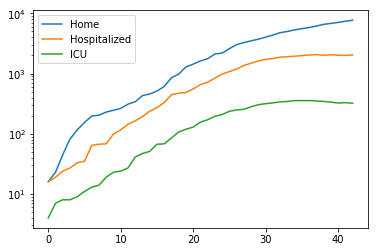

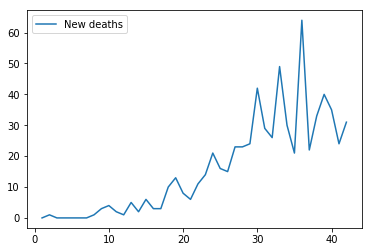

In [124]:
plt.plot(group["home_isolation"], label='Home')
plt.plot(group["total_hospitalized"], label='Hospitalized')
plt.plot(group["intensive_care"], label='ICU')
plt.yscale('log')
plt.legend()
plt.show()


# plt.plot(group["total_positive_change"], label='New cases')
plt.plot(group["new_deaths"], label='New deaths')
# plt.plot(group["intensive_care"], label='ICU')
# plt.yscale('log')
plt.legend()
plt.show()


In [84]:
! git status


On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   01_eda_italy.ipynb
	modified:   ../basic_model_framework.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [85]:
!git stash

Saved working directory and index state WIP on master: 4fc5978 daily update


In [86]:
!git pull origin master

remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 23 (delta 8), reused 11 (delta 4), pack-reused 0
Unpacking objects: 100% (23/23), done.
From https://github.com/Yu-Group/covid-19-ventilator-demand-prediction
 * branch            master     -> FETCH_HEAD
   4fc5978..aac7083  master     -> origin/master
Updating 4fc5978..aac7083
Fast-forward
 county_quickstart.ipynb          |  47 ++++++++++-
 data/02_county_FIPS.csv          |   6 +-
 data/nytimes/confirmed_cases.csv | 161 ++++++++++++++++++------------------
 data/nytimes/deaths.csv          | 162 ++++++++++++++++++------------------
 functions/emerging_index.py      |  35 ++++----
 results/emerging_hotspots.html   |  31 +++++++
 viz/viz_interactive.py           | 173 +++++++++++++++++++++++++++------------
 7 files changed, 374 insertions(+), 241 deletions(-)
 create mode 100644 results/emerging_hotspots.html


## China Data

In [179]:
china = pd.read_csv("https://raw.githubusercontent.com/BlankerL/DXY-COVID-19-Data/master/csv/DXYArea.csv")

In [181]:

china = china[china["countryEnglishName"]=='China']

In [187]:
china[china["provinceEnglishName"] =="China"][["updateTime","province_deadCount", "province_confirmedCount"]].sort_values("updateTime")[:12]

,updateTime,province_deadCount,province_confirmedCount
56202,2020-03-15 19:24:16,3204,81059
56186,2020-03-15 21:24:35,3204,81061
56161,2020-03-15 21:41:38,3204,81062
55747,2020-03-16 07:45:27,3204,81063
55726,2020-03-16 08:06:00,3204,81068
55723,2020-03-16 08:18:42,3204,81068
55718,2020-03-16 08:24:31,3204,81070
55684,2020-03-16 08:26:46,3204,81070
55653,2020-03-16 08:44:01,3218,81077
55634,2020-03-16 09:39:00,3218,81079
